<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Unsupervised%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Common Unsupervised Learning Tasks:
- **Dimensionality Reduction**
<br> - Reducing the number of variables/features in a dataset while retaining essential information
<br> - Principal Component Analysis (PCA)
- **Clustering**
<br> - Grouping similar instances based on their features into clusters
<br> - K-Means Clustering
- **Anomaly/Outlier Deterction**
<br> - Learning what "normal" data (inliers) looks like then use the knowledge to detect abnormal instances (outliers)
<br> - Used in Fraud detection, Detecting Defective products, etc.
- **Density Estimation**
<br> - Estimating the probability density function (PDF) of the random process that generated the dataset.
<br> - Kernel Density Estimation (KDE)

## K-Means Clustering

Train a K-Means clusterer on a dataset if blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5 # based on the given dataset, k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance will be assigned to 1 of the 5 clusters. An instance's label is the index of the cluster it has been assigned to. The KMeans instance preserves the predicted labels of the instances it was trained on:

In [2]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

The 5 centroids can also be identified:

In [3]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

New instances can be easily assigned to the cluster whose centroid is closest:

In [4]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]) # New instances
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

The distance between each instance to every centroid can be measured using:

In [5]:
kmeans.transform(X_new).round(2)

array([[0.12, 2.9 , 2.84, 1.5 , 0.63],
       [3.07, 5.85, 5.82, 4.48, 2.56],
       [3.07, 0.29, 1.46, 1.69, 3.52],
       [2.96, 0.36, 0.97, 1.54, 3.47]])

From the output, the first instance in X_new is located at a distance of about 0.12 from the first centroid, 2.9 from second centroid.

### Centroid Initilization Methods
If the approximation of the centroids' coordinates is known (if another clustering algorithm was ran earlier), then the ```n_init``` hyperparameter can be set to 1:

In [6]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]]) # Approximation of centroids's coords

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

If the approximation of the centroids' coordinates is unknown, the K-Means alrogithm can be run multiple times with different random initializations to determine the best solution. <br><br>
The number of random initilizations is controlled by the ```n_init``` hyperparamter, which by default, is set to 10. A performance metric called the model's *inertia* is used by Scikit-Learn to determine the best solution. A model's inertia is the sum of the squared distances between the instances and their closest centroids.

In [7]:
kmeans.inertia_

211.59853725816828

### Finding the Optimal Number of Clusters
```silhouette_score``` can be used to choose the best value for the number of clusters. Silhoutte score is the mean of silhouette coefficient over all instances, which is equal to **(b-a) / max(a,b)**, where **a** is the mean distance to other instances within the same cluster (mean intra-cluster distance) and **b** is the mean nearest-cluster distance.

In [8]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

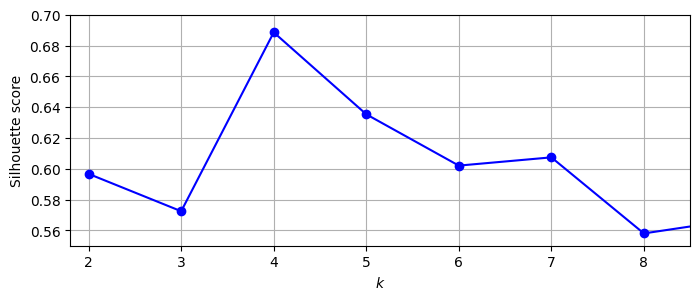

In [9]:
import matplotlib.pyplot as plt

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
plt.show()

From the visualization, it highlights that k=5 is the optimal cluster size.

## Using Clustering for Image Segmentation

Image Segmentation is the partitioning of an image into multiple segments:
- **Color Segmentation:** Pixels with a similar color get assigned to the same segment. For example, to measure how much forest area there is in a region, color segmentation can be used.
- **Semantic Segmentation:** Pixels that are part of the same object type gets assigned to the same segment. For example, in a self-driving car's vision system, pixels that are part of a pedestrian's image are assigned to the "pedestrain" segment.
- **Instance Segmentation:** Pixels that are part of the same individual object are assigned to the same segment. For example, for each pedestrain, there exists a different segment.

The following code uses ```PIL``` package to load the ladybug image:

In [10]:
import PIL
import urllib.request
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

The following code reshapes the array to get a list of RGB colors then it clusters these colors using k-means with 8 clusters. A "segmented_img" array is then created which contains the nearest cluster center for each pixel. Lastly, the array is reshaped back to the original image shape.

In [11]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

The following code shows the output of the image semgentation using k-means with various numbers of color clusters:

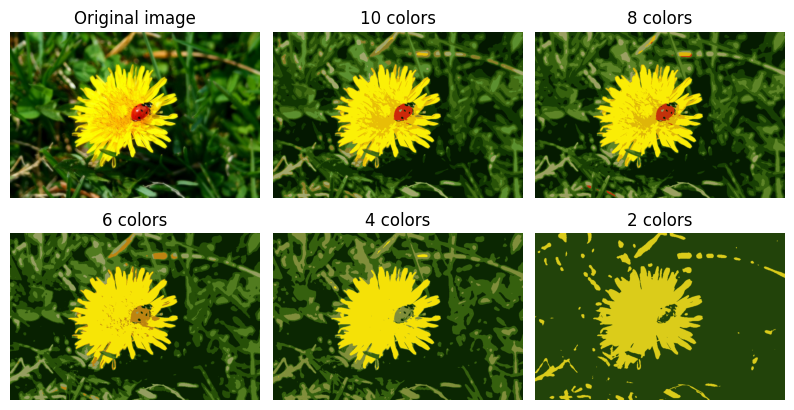

In [12]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

## Using Clustering for Semi-Supervised Learning
In this example, the digits dataset will be used. First, load and split the dataset:

In [13]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Assuming that there are only labels for 50 instances, to get a baseline performance, train a `LogisticRegression` model on these 50 labelled instances:

In [14]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

Measure the accuracy of this model on the test set:

In [15]:
log_reg.score(X_test, y_test)

0.7581863979848866

The accuracy of the model is only 75.8%, which is not great. To try improve the model, first cluster the training set into 50 clusters, then for each cluster, find the image closest to the centroid. These images are also knwon as "Representative Image".

In [16]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Plot these representative images and label them manually:

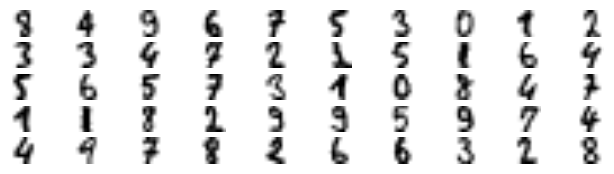

In [17]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [18]:
y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
    3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
    1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 2, 6, 3, 2, 8
])

Test the performance again, to see if it has improved:

In [19]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8136020151133502

The model's accuracy has indeed improved from 75.8% to 81.4%, although the model is only trained on 50 instances. Since it can be difficult to manually label each instances, it is a good idea to just label the representative instances.

By propagating the labels to other instances in the same cluster, the accuracy might improve further. This is also known as Label Propagation:

In [20]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
  y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

Check the model's performance:

In [21]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)


0.8639798488664987

The model's accuracy improved slightly. To further improve the model, 1% of instances that are farthest from their cluster center can be ignored, which should eliminate some outliers.
<br><br>
The following code first computes the distance from each instance to its closest cluster center. Then, for each cluster it sets the 1% largest distances to "-1". Lastly, a set without these instances are created.

In [22]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

Check the model's performance:

In [23]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8463476070528967

## Gaussian Mixture Model (GMM)

GMM is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian Distributions whose parameters are unknwon.

In [24]:
# Generate a dataset with 3 ellipsoid
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [25]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Observe the parameters that the algorithm estimated:

In [26]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [27]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [28]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Check if the algorithm covered and how many iterations it took:

In [29]:
gm.converged_

True

In [30]:
gm.n_iter_

4

Given that the estimation of the location, size, shape, orientation and relative weight of each cluster is now known, the model can assign each instance to the most likely cluster (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering). `predict` for hard clustering, `predict_proba` for soft clustering.

In [31]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [32]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

Since a GMM is a Generative Model, new instances can be sampled from it:

In [33]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [34]:
y_new

array([0, 0, 1, 1, 1, 2])

### Using Gaussian Mixtures for Anomaly Detection
ANy instance located in a low-density region can be considered as an anomaly. A density threshold must be defined. For example, in a manufacturing company that tries to detect defective products, the ratio of
defective products is usually well known. Say it is equal to 2%. Hence, the density threshold can be set to 2%. If there are too many false positives (good products flagged as defectives), lower the threshold and vice-versa.

In [35]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

The following visualization represents these anomalies as stars:

In [36]:
# Function for plotting GMM
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Function for plotting centroids
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

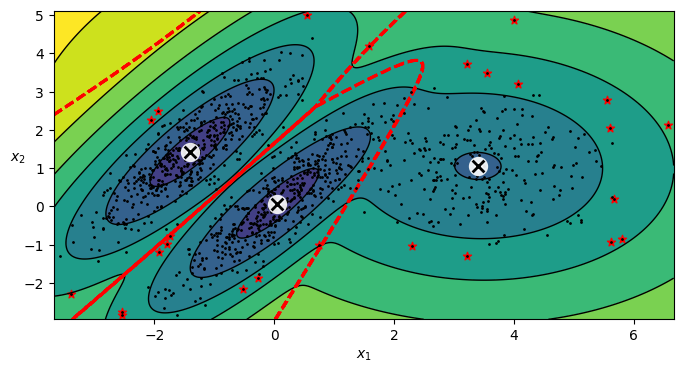

In [37]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

### Bayesian Gaussian Mixture Models
Rather than manually searching for the optimal number of clusters, use the `BayesianGaussianMixture` class, which gives weights equal to zero to unnecessary clusters. Set the number of clusters `n_components` to a value that is belived to be greater than the optimal number of clusters, and the algorithm will automatically eliminate the unnecessary clusters. <br>For example, the following code sets the number of clusters to 10:

In [38]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

The algorithm detected that only 3 clusters are necessary (those that have weights).